In [1]:
from __future__ import division #For decimal division.
import numpy as np #For use in numerical computation.
import pandas as pd #Pandas.
from functools import reduce #For finding intersection of rows in pandas dataframes.
import glob, os #For finding files inside folder.
import time #Check time of computation.
from sklearn.model_selection import train_test_split #Split arrays or matrices 
													#into random train and test subsets
from sklearn.preprocessing import StandardScaler #Centering and scaling each feature independently 
                                                 #by removing the mean and scaling to unit variance                          
from sklearn.decomposition import PCA #Principal component analysis (PCA). 
from sklearn.linear_model import LogisticRegression #Logistic Regression.                     
import matplotlib.pyplot as plt #Matplotlib
from matplotlib.colors import ListedColormap
from plots import plot_labels #Self defined function for scatter plot of labels 
from plots import plot_explained_variance #Self defined function for plottting
                                          #cumulative and principal explained variances.

# Create output folders

In [2]:
if( not os.path.isdir("images") ): 
    print "'images' folder does not exist. Creating 'images' folder." 
    try:
        os.makedirs('images/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# Import files

In [3]:
"""
Notes
----------
> Raw data has 17382 cells and ~80k features (union of genes).

Important parameters
----------	
files : list data type (stores list of *.txt files inside 'data_cell_gene/')
dfs : list data type (contains list of pandas dataframes which are imported from *.txt files in list 'files'.)
"""
start_time = time.time()

files = glob.glob("data_cell_gene/*.txt")
dfs = [ pd.read_csv(files[i], sep='\t', header=[0,1], index_col=0) for i in range(len(files)) ]

# Dimensionality Reduction

In [4]:
"""
Notes
----------
> Dimensionality reduction from ~80k features (union of genes) to 6460 features (intersection of genes).

Important parameters
----------	
df_final : list data type (pandas dataframe which contains intersection of rows of dataframes contained in list 'dfs'.)    
"""
df_final = reduce(lambda left,right: pd.merge(left,right,on=None,left_index=True,right_index=True), dfs)	

file_read_time = time.time()
print("--- Import and processing of all cell-gene data files completed in %s seconds o_o ---" % (file_read_time - start_time))

--- Import and processing of all cell-gene data files completed in 392.79180789 seconds o_o ---


# Data acquisition

In [5]:
"""
Notes
----------
Obtain data from df_final.

Important parameters
----------	
data_num : numpy.ndarray data type, of shape ( m , n ). (stores numerical data from df_final.)
cells_tot_sup : numpy.ndarray data type of shape ( m , ).  (list of cells (columns) from df_final.)
cells_unq_sup : numpy.ndarray data type of shape ( m1 , ).  (list of unique cells in df_final.)  
genes_sup : numpy.ndarray data type of shape ( m2 , ).	(list of genes/features (rows) from df_final.)	   
"""
data_num = df_final.values
cells_tot_sup = np.asarray( df_final.columns.get_level_values(1).tolist() ) 
cells_unq_sup = np.unique(cells_tot_sup)
genes_sup = np.asarray( (df_final.index).tolist() )

# Biologically related genes (protein-DNA/ protein-protein)

In [6]:
"""
Notes
----------
> Use protein-protein and protein-DNA data to find similarity between genes. And use this for DIMENSIONALITY REDUCTION.
> Dimensionality reduction from 6460 features (genes) to 348 features (genes) after 
  incorporation of protein-protein and protein-DNA gene similarity data.

Important parameters
----------	
df_protein_DNA : Pandas dataframe with protein-DNA/ protein-protein.
df_protein_DNA_genes : Pandas dataframe 'df_protein_DNA' with genes from 'genes_sup' (and nothing else). 
df_similar_genes : Pandas dataframe with similar genes in different rows.
gene_similar_LoL : List of lists with similar genes in different lists.
"""
time_protein_DNA_start = time.time()

fpath_protein_DNA = 'data_protein_DNA/ppi_tf_merge_cluster.txt'
df_protein_DNA = pd.read_csv(fpath_protein_DNA, error_bad_lines=False, warn_bad_lines=False, sep=r'\t+', header=None, dtype='|U', engine='python')
df_protein_DNA_genes = ( df_protein_DNA.stack().reset_index(0,name='genes')
	                                   .merge(pd.DataFrame({'genes':genes_sup}))
	                                   .set_index('level_0') )
df_protein_DNA_genes['length'] = df_protein_DNA_genes.groupby('level_0').transform('nunique')
df_similar_genes = ( pd
	.DataFrame({'row_num':df_protein_DNA_genes.groupby('genes')['length'].idxmax().values})
    .groupby('row_num')
    .apply(lambda x: list(x.index)) )

gene_similar_LoL = df_similar_genes.tolist()

data_num_similar_gene = np.stack([np.mean(data_num[el], 0) for el in gene_similar_LoL if el]) 

time_protein_DNA_end = time.time()
print("--- Import and processing of protein-protein and protein-DNA data files completed in %s seconds o_o ---" % (time_protein_DNA_end - time_protein_DNA_start))

--- Import and processing of protein-protein and protein-DNA data files completed in 2.04592013359 seconds o_o ---


# Data splitting

In [7]:
"""
Notes
----------
Split input array into random train and test subsets

Important parameters
----------	
X_train : numpy.ndarray data type, of shape ( num_train , genes_sup.shape[0] ). 
              (Training data split from data_num_similar_gene.T .)
X_test : numpy.ndarray data type, of shape ( num_test , genes_sup.shape[0] ). 
              (Test data split from data_num_similar_gene.T.)
y_train : numpy.ndarray, of shape ( num_train , ). (Labels coresponding to X_train.)
y_test : numpy.ndarray, of shape ( num_test , ). (Labels coresponding to X_test.)
Number of features : genes_sup.shape[0] (number of features = number of genes)
"""
X_train, X_test, y_train, y_test = \
				train_test_split(data_num_similar_gene.T, cells_tot_sup, test_size=0.25, random_state=125)

print data_num.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

(6460, 17382) (13036, 348) (4346, 348) (13036,) (4346,)


# Data processing

In [8]:
"""
Feature scaling of X_train, X_test.
"""		
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# Covariance

In [9]:
"""
Construct covariance matrix from X_train_std.
"""		  
time_start_cov = time.time()
cov_mat = np.cov(X_train_std.T)
time_end_cov = time.time()
print("--- Covariance matrix computed in %s seconds o_o ---" % (time_end_cov - time_start_cov))	
print 'Shape of covariance matrix is: ', cov_mat.shape  


"""
Find eigen values and eigen vectors of covariance matrix.
"""		  
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
time_eigen = time.time()
print("--- Eigen vectors and values computed in %s seconds o_o ---" % (time_eigen - time_end_cov))	

tot_eigval = sum(eigen_vals)

var_exp = [(i/tot_eigval) for i in sorted(eigen_vals, reverse=True)]
scale_factor = 10
var_exp_scaled = [ i*scale_factor for i in var_exp]

cum_var_exp = np.cumsum(var_exp)


--- Covariance matrix computed in 0.0777719020844 seconds o_o ---
Shape of covariance matrix is:  (348, 348)
--- Eigen vectors and values computed in 0.0714139938354 seconds o_o ---


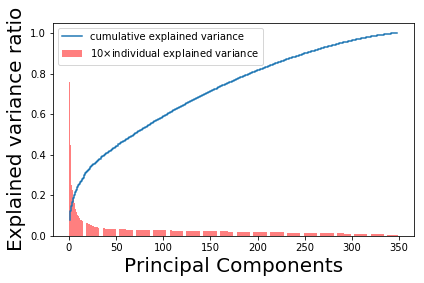

In [10]:
"""
Notes (Plotting)
----------
This function plots cumulative and principal explained variances.
"""
fignum = 1
plot_explained_variance( var_exp=var_exp, var_exp_scaled=var_exp_scaled, scale=scale_factor,
	                     cum_var_exp=cum_var_exp, numfig=fignum, saveplot=False )
fignum+=1

# Machine Learning

In [11]:
"""
Notes (Principal Component Analysis)
----------
> You fit PCA on the training set only.
> Mapping (transform) is applied to both the training and the test sets.
> Helpful link (https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
"""	
energy = 0.95	  	
pca = PCA(energy)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)


"""
Fitting Logistic Regression after PCA.
Helpful link (https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
"""		  	
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)
y_test_pred = lr.predict(X_test_pca)

print "Mean accuracy on test data and labels is: ", lr.score(X_test_pca, y_test)

Mean accuracy on test data and labels is:  0.9408651633686148


In [12]:
"""
Notes (Plotting)
----------
> This function plots  class labels information for the purpose of illustration.
> Keep in mind that PCA is an unsupervised technique that doesn't use class label information.
"""
plot_labels(XX=X_test_pca, yy=y_test, yy_pred=y_test_pred, numfig=fignum, saveplot=False)

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
